In [6]:
from datasets import load_dataset
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/deyuq/COMP9444/9444proj/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
emotions = load_dataset("dair-ai/emotion")

In [8]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [9]:
train_data = emotions["train"]
validation_data = emotions["validation"]
test_data = emotions["test"]

In [10]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [11]:
train_preprocess = np.array(train_data["text"]).reshape(-1,1)
train_preprocess

array([['i didnt feel humiliated'],
       ['i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
       ['im grabbing a minute to post i feel greedy wrong'],
       ...,
       ['i feel strong and good overall'],
       ['i feel like this was such a rude comment and im glad that t'],
       ['i know a lot but i feel so stupid because i can not portray it']],
      dtype='<U300')

In [12]:
oversample = RandomOverSampler()
train_text_oversample, train_data_oversample = oversample.fit_resample(train_preprocess, train_data["label"])
len(train_text_oversample)

32172

In [13]:
from collections import Counter

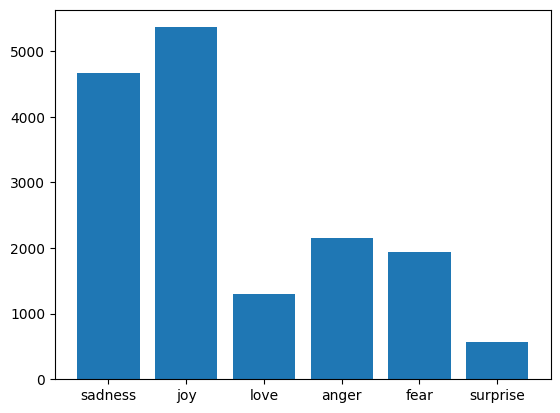

In [14]:
label_count = Counter(train_data["label"])
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

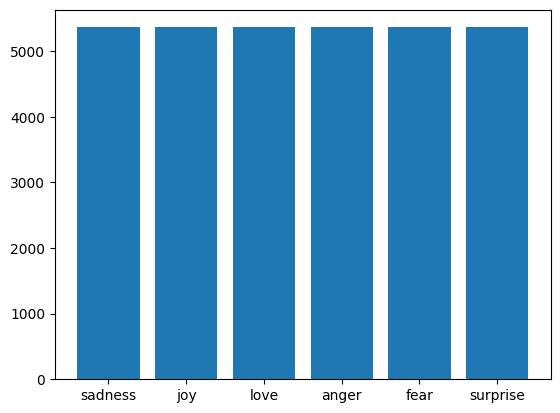

In [15]:
label_count = Counter(train_data_oversample)
label_list = dict(sorted(label_count.items())).values()
fig, ax = plt.subplots()
ax.bar(labels, label_list)
plt.show()

In [16]:
# Tokenization
vocab_n = 5000
sequence_len = 64

# Initialize a tokenizer using BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(length=sequence_len)
tokenizer.enable_truncation(max_length=sequence_len)
tokenizer_trainer = trainers.BpeTrainer(vocab_size=vocab_n)
tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)

In [17]:
def preprocess_text(text: str, tokenizer: Tokenizer):
    """ 
    Helper function to tokenize text and return corresponding token IDs as tensors.

    Args:
        text, str: Text instance from training data.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        Tensor: One-dimensional PyTorch tensor with token IDs.
    """
    return torch.tensor(tokenizer.encode(text).ids)


def preprocess_label(label: int):
    """ 
    Helper function to return label as tensor.

    Args:
        label, int: Label from instance.
    Returns:
        Tensor: One-dimensional PyTorch tensor containing the label index.
    """
    return torch.tensor(label)


def preprocess(data: dict, tokenizer: Tokenizer):
    """ 
    Transforms input dataset to tokenized vector representations.

    Args:
        data, dict: Dictionary with text instances and labels.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(data["text"], data["label"]):
        input = preprocess_text(text, tokenizer)
        label = preprocess_label(label)
        
        instances.append((input, label))

    return instances

In [18]:
train_instances = preprocess(train_data, tokenizer)
val_instances = preprocess(validation_data, tokenizer)
test_instances = preprocess(test_data, tokenizer)

In [19]:
val_instances

[(tensor([  66,   55,  464,  599,   42,  962,   78,  193,   92,  171,   18, 3424,
            77,   53,   44, 1263,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0]),
  tensor(0)),
 (tensor([   8,   31,   79,    8,   70,  248,  756,   35,    0, 1490, 4678, 1490,
          2912,   53, 1923,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0]),
  tensor(0)),
 (tensor([   8,   31,   79,    0, 1471, 1844,  104,    0,    0,    0,    0,    0

In [20]:
# Batching

def batching(instances: list, batch_size: int, shuffle: bool):
    """ 
    Batches input instances along the given size and returns list of batches.

    Args:
        instances, list: List of instances, containing a tuple of two tensors 
            for each text as well as corresponding label.
        batch_size, int: Size for batches.
        shuffle, bool: If true, the instances will be shuffled before batching.
    Returns:
        list: List containing tuples that correspond to single batches.
    """
    if shuffle:
        random.shuffle(instances)

    batches = []

    # We iterate through the instances with batch_size steps
    for i in range(0, len(instances), batch_size):

        # Stacking the instances with dim=0 (default value)
        batch_texts = torch.stack(
            [instance[0] for instance in instances[i : i + batch_size]]
        )
        batch_labels = torch.stack(
            [instance[1] for instance in instances[i : i + batch_size]]
        )

        batches.append((batch_texts, batch_labels))
    
    return batches

In [38]:
# CNN Network

class CNN_Classifier(nn.Module):
    """ 
    CNN for sentiment classification with 6 classes, consisting of an embedding 
    layer, two convolutional layers with different filter sizes, different 
    pooling sizes, as well as one linear output layer.
    """
    def __init__(self):
        super().__init__()
        # We can implement embeddings as a simple lookup-table for given word 
        # indices
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), 300)

        # One-dimensional convolution-layer with 300 input channels, and 100  
        # output channels as well as kernel size of 3; note that the
        # one-dimensional convolutional layer has 3 dimensions
        self.conv_1 = nn.Conv1d(300, 100, 3, padding="same")

        # Pooling with with a one-dimensional sliding window of length 3, 
        # reducing in this fashion the sequence length 
        self.pool_1 = nn.MaxPool1d(3)

        # The input will be the reduced number of maximum picks from the
        # previous operation; the dimension of those picks is the same as the
        # output channel size from self.conv_1. We apply a different filter of 
        # size 5.
        self.conv_2 = nn.Conv1d(100, 50, 5, padding="same")

        # Pooling with window size of 5
        self.pool_2 = nn.MaxPool1d(5)

        self.lstm = nn.LSTM(50, 150, dropout=0.5)

        self.dropout = nn.Dropout(0.5)

        # Final fully connected linear layer from the 50 output channels to the
        # 6 sentiment categories 
        self.linear_layer = nn.Linear(150, 6)

    def forward(self, x):
        """ 
        Defining the forward pass of an input batch x.

        Args:
            x, tensor: The input is a batch of tweets from the data.
        Returns:
            y, float: The output are the logits from the final layer.
        """
        # x will correspond here to a batch; therefore, the input dimensions of 
        # the embedding will be by PyTorch convention as follows:
        # [batch_size, seq_len, emb_dim]
        x = self.embedding(x)

        # Unfortunately the embedding tensor does not correspond to the shape 
        # that is needed for nn.Conv1d(); for this reason, we must switch its 
        # order to [batch_size, emb_dim, seq_len] for PyTorch
        x = x.permute(0, 2, 1)

        # We can wrap the ReLu activation function around our convolution layer
        # The output tensor will have the following shape: 
        # [batch_size, 100, seq_len]
        x = nn.functional.relu(self.conv_1(x))

        # Applying max pooling of size 3 means that the output length of the 
        # sequence is shrunk to seq_len//3
        x = self.pool_1(x)

        # Output of the following layer: [batch_size, 50, seq_len//3]
        x = nn.functional.relu(self.conv_2(x))

        # Shrinking the sequence length by 5
        x = self.pool_2(x)
        # print(x.shape)

        # At this point we have a tensor with 3 dimensions; however, the final layer 
        # requires an input of size [batch_size x 50]. To get this value we can 
        # aggregate the values and continue only with their mean
        x = x.mean(dim=-1)

        output, (hidden, cell) = self.lstm(x)
        hidden = hidden.squeeze(0)

        dropouts = self.dropout(hidden)

        # In this fasion, the linear layer can be used to make predictions
        y = self.linear_layer(dropouts)

        return y
    
    def fit(self, train_instances, val_instances, epochs, batch_size):
        """ 
        Gradient based fitting method with Adam optimization and automatic 
        evaluation (F1 score) for each epoch.

        Args:
            train_instances, list: List of instance tuples.
            val_instances, list: List of instance tuples.
            epochs, int: Number of training epochs.
            batch_size, int: Number of batch size.
        """
        self.train()
        optimizer = torch.optim.Adam(self.parameters())

        for epoch in range(epochs):
            train_batches = batching(
                train_instances,
                batch_size=batch_size,
                shuffle=True)
            
            for inputs, labels in tqdm(train_batches):
                optimizer.zero_grad()
                outputs = self(inputs)
                # turn long tensor to float tensor
                # print(labels)
                labels = labels.type(torch.FloatTensor)
                print(outputs)
                print(labels)
                loss = nn.functional.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
            
            train_f1 = self.evaluate(train_instances, batch_size=batch_size)
            val_f1 = self.evaluate(val_instances, batch_size=batch_size)

            print(f"Epoch {epoch + 1} train F1 score: {train_f1}, validation F1 score: {val_f1}")

    def predict(self, input):
        """ 
        To make inferences from the model.

        Args:
            input, tensor: Single instance.
        Returns:
            int: Integer for most probable class.
        """
        self.eval()
        outputs = self(input)

        return torch.argmax(outputs, dim=-1)

    def evaluate(self, instances, batch_size):
        """ 
        To evaluate model's performance by various processes/standard.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        y_test = []
        y_pred = []

        for inputs, labels in batches:
            y_test.extend(labels)
            y_pred.extend(self.predict(inputs))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print("CNN Classifier:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")

In [40]:
classifier = CNN_Classifier()
classifier.fit(train_instances, val_instances, epochs=5, batch_size=6)

  1%|          | 19/2667 [00:00<00:26, 98.20it/s]

tensor([-0.0223, -0.0058, -0.0130,  0.0511, -0.0145, -0.0260],
       grad_fn=<ViewBackward0>)
tensor([5., 1., 0., 4., 0., 3.])
tensor([ 0.1266, -0.0826, -0.0814,  0.0573, -0.0371, -0.0504],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 3., 4., 0., 1.])
tensor([ 0.1866, -0.0984, -0.1529,  0.1894, -0.0975,  0.0097],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 0., 0., 0., 1.])
tensor([ 0.2935, -0.1909, -0.3316, -0.0381, -0.1023, -0.0691],
       grad_fn=<ViewBackward0>)
tensor([3., 3., 0., 3., 1., 0.])
tensor([ 0.5974, -0.0013, -0.4958,  0.5339, -0.2882, -0.0037],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 1., 1., 2., 0.])
tensor([ 0.4612,  0.0293, -0.5030,  0.3438, -0.0153, -0.1530],
       grad_fn=<ViewBackward0>)
tensor([4., 3., 1., 4., 0., 3.])
tensor([ 0.4039, -0.0188, -0.1501,  0.2224, -0.2141,  0.0691],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 0., 1., 3., 1.])
tensor([ 0.7829,  0.0465, -0.5385,  0.2652, -0.2796,  0.1881],
       grad_fn=<ViewBackward0>)
tensor([3

  2%|▏         | 49/2667 [00:00<00:20, 128.95it/s]

tensor([ 0.0461, -0.0594,  0.2757, -0.0958, -0.2886,  0.2184],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 2., 0., 3., 0.])
tensor([ 0.4272, -0.1394, -0.0585,  0.1070, -0.2673, -0.0574],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 0., 4., 3., 1.])
tensor([ 0.0538,  0.0735, -0.1808, -0.0682, -0.3685,  0.0890],
       grad_fn=<ViewBackward0>)
tensor([5., 1., 1., 4., 2., 1.])
tensor([ 0.2854, -0.0944, -0.0364,  0.0181,  0.0447, -0.0915],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 0., 0., 1., 4.])
tensor([ 0.1416, -0.2129, -0.1943,  0.1794, -0.1298, -0.1709],
       grad_fn=<ViewBackward0>)
tensor([5., 0., 3., 0., 1., 2.])
tensor([ 0.2030, -0.2611, -0.2824,  0.1601, -0.0299, -0.1899],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 0., 0., 1., 4.])
tensor([ 0.4182, -0.2071, -0.3259, -0.0324, -0.1107, -0.1141],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 1., 0., 0., 0.])
tensor([ 0.3877, -0.1294, -0.2092,  0.0758, -0.1779, -0.0847],
       grad_fn=<ViewBackward0>)
tensor([1

  3%|▎         | 83/2667 [00:00<00:17, 151.68it/s]

tensor([ 0.2140, -0.2002,  0.0306, -0.0859,  0.0278, -0.0388],
       grad_fn=<ViewBackward0>)
tensor([4., 2., 4., 3., 3., 4.])
tensor([ 0.1496, -0.2603,  0.0269, -0.0138,  0.0030, -0.0805],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 0., 2., 0., 0.])
tensor([ 0.0798, -0.2194,  0.1223, -0.1235,  0.1276, -0.0592],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 0., 1., 0., 1.])
tensor([-0.0049, -0.1488,  0.1425, -0.0986,  0.0890, -0.0375],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 1., 5., 1., 1.])
tensor([-0.0652, -0.1650,  0.0575, -0.0530,  0.1181, -0.1073],
       grad_fn=<ViewBackward0>)
tensor([3., 3., 3., 4., 4., 4.])
tensor([ 0.1132, -0.1950,  0.0319, -0.1544,  0.0606, -0.0976],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 4., 3., 1., 0.])
tensor([ 0.1338, -0.0993, -0.0576, -0.0333, -0.0346, -0.1304],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 0., 4., 5.])
tensor([ 0.0128, -0.1586,  0.0266, -0.0928,  0.0166, -0.0100],
       grad_fn=<ViewBackward0>)
tensor([0

  4%|▍         | 115/2667 [00:00<00:16, 151.63it/s]

tensor([-0.0382, -0.0937,  0.0061,  0.0670,  0.0544, -0.0272],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 1., 2., 0., 1.])
tensor([-0.0051, -0.0753, -0.0243,  0.0560,  0.1048, -0.0187],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 5., 2., 0.])
tensor([ 0.0039, -0.1038, -0.0291,  0.0214, -0.0226,  0.0296],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 4., 2., 1., 0.])
tensor([-0.0539, -0.1375, -0.0142,  0.0611,  0.0560, -0.0316],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 1., 1., 1., 4.])
tensor([-0.1146, -0.0950, -0.0191,  0.0468,  0.0503, -0.0862],
       grad_fn=<ViewBackward0>)
tensor([5., 1., 1., 4., 3., 3.])
tensor([-0.0471, -0.0896, -0.0529,  0.0423,  0.0693, -0.0167],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 0., 4., 0., 0.])
tensor([-0.0164, -0.0756, -0.0647,  0.0227,  0.0405, -0.0660],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 1., 1.])
tensor([-0.0531, -0.0967, -0.0275,  0.0609,  0.0774, -0.0373],
       grad_fn=<ViewBackward0>)
tensor([3

  6%|▌         | 147/2667 [00:01<00:16, 149.74it/s]

tensor([-0.0371, -0.0403, -0.0207, -0.0088,  0.0342,  0.0399],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 3., 4., 1., 0.])
tensor([ 0.0203, -0.0385, -0.0126, -0.0188,  0.0128,  0.0077],
       grad_fn=<ViewBackward0>)
tensor([4., 3., 1., 1., 1., 4.])
tensor([ 0.0108, -0.0500, -0.0256, -0.0308,  0.0418,  0.0443],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 0., 0., 1., 0.])
tensor([-0.0099, -0.0129, -0.0969, -0.0203, -0.0232,  0.0208],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 0., 3., 1., 5.])
tensor([-0.0336, -0.0175, -0.0698,  0.0111,  0.0685,  0.0326],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 0., 3., 1.])
tensor([ 0.0137,  0.0002, -0.0418,  0.0262,  0.0447, -0.0041],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 0., 1., 5., 1.])
tensor([ 0.0229,  0.0456,  0.0002, -0.0230,  0.0617,  0.0194],
       grad_fn=<ViewBackward0>)
tensor([2., 4., 0., 1., 1., 5.])
tensor([ 0.0805,  0.0117, -0.0844, -0.0252, -0.0154,  0.0022],
       grad_fn=<ViewBackward0>)
tensor([0

  7%|▋         | 186/2667 [00:01<00:14, 173.90it/s]

tensor([ 0.0971, -0.0141, -0.0747, -0.0358,  0.0224, -0.0509],
       grad_fn=<ViewBackward0>)
tensor([1., 5., 3., 1., 1., 0.])
tensor([ 0.0758, -0.0009, -0.0622, -0.0224, -0.0100, -0.0181],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 4., 1., 2., 0.])
tensor([ 0.1143, -0.0188, -0.1046, -0.0198,  0.0358,  0.0017],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 5., 1., 5.])
tensor([ 0.1000, -0.0686, -0.0737, -0.0390, -0.0673, -0.0229],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 1., 3., 2.])
tensor([ 0.0882,  0.0264, -0.0739,  0.0166, -0.0007, -0.0015],
       grad_fn=<ViewBackward0>)
tensor([3., 3., 3., 2., 3., 4.])
tensor([-0.0065, -0.0615, -0.1161,  0.0358,  0.0304, -0.0323],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 3., 1., 1., 1.])
tensor([ 0.0610, -0.0249, -0.0598, -0.0426, -0.0056, -0.0328],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 1., 0., 0., 0.])
tensor([ 0.0567, -0.0089, -0.0474, -0.0316, -0.0143, -0.0591],
       grad_fn=<ViewBackward0>)
tensor([1

  9%|▉         | 236/2667 [00:01<00:11, 211.61it/s]

tensor([ 0.1265, -0.0374, -0.0412,  0.0521,  0.0388, -0.0763],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 0., 1., 0., 1.])
tensor([ 0.0447, -0.0622, -0.0130,  0.0413,  0.0276, -0.0805],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 0., 1., 2.])
tensor([ 0.0461, -0.0865, -0.0358,  0.0125,  0.0320, -0.0436],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 2., 1., 0., 4.])
tensor([ 0.0236, -0.0459, -0.0222,  0.0194,  0.0271, -0.0828],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 2., 4., 1., 0.])
tensor([ 0.0710, -0.0154,  0.0065,  0.0428,  0.0045, -0.0984],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 3., 0., 1.])
tensor([ 0.0325, -0.0348, -0.0331, -0.0073,  0.0168, -0.0554],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 4., 3., 1., 3.])
tensor([ 0.0606, -0.0575, -0.0212,  0.0344, -0.0266, -0.0552],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 4., 3., 1., 4.])
tensor([ 0.0871, -0.0017, -0.0179,  0.0303,  0.0195, -0.0186],
       grad_fn=<ViewBackward0>)
tensor([1

 11%|█         | 290/2667 [00:01<00:10, 237.11it/s]

tensor([-0.0044,  0.1086,  0.1714, -0.0248, -0.0225, -0.1249],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 0., 0., 0., 1.])
tensor([ 0.0425,  0.1274,  0.2911, -0.0310,  0.0231, -0.1140],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 4., 0., 5., 1.])
tensor([ 0.0188,  0.0554,  0.2080,  0.0170, -0.0214, -0.0978],
       grad_fn=<ViewBackward0>)
tensor([3., 2., 1., 2., 3., 1.])
tensor([-0.0407,  0.0685,  0.1937, -0.0278,  0.0122, -0.2274],
       grad_fn=<ViewBackward0>)
tensor([2., 3., 0., 1., 0., 2.])
tensor([-0.0163,  0.0727,  0.2881, -0.0795,  0.0134, -0.1090],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 0., 4., 3., 1.])
tensor([-0.0568,  0.0226,  0.1863, -0.0489, -0.0166, -0.0828],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 5., 0., 0.])
tensor([-0.0489,  0.0487,  0.1792, -0.0482,  0.0361, -0.1808],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 1., 0., 1., 1.])
tensor([ 0.0519,  0.0770,  0.1721, -0.0080, -0.0183, -0.1289],
       grad_fn=<ViewBackward0>)
tensor([3

 13%|█▎        | 342/2667 [00:01<00:09, 246.75it/s]

tensor([ 0.1099,  0.0570, -0.0013,  0.0055, -0.0858, -0.0668],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 4., 0., 1., 4.])
tensor([ 0.1345,  0.0372,  0.0093, -0.0158, -0.1068, -0.0567],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 0., 1., 0.])
tensor([ 0.1595,  0.0231,  0.0333, -0.0359, -0.1006, -0.0471],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 3., 0., 0., 0.])
tensor([ 0.1319,  0.0022,  0.0358, -0.0259, -0.1017, -0.0502],
       grad_fn=<ViewBackward0>)
tensor([4., 3., 3., 2., 0., 0.])
tensor([ 0.0506,  0.0283, -0.0002, -0.0384, -0.0574, -0.0384],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 0., 1., 0.])
tensor([ 0.1191,  0.0136,  0.0369, -0.0413, -0.1202, -0.0379],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 0., 2., 3., 2.])
tensor([ 0.1095,  0.0510,  0.0544, -0.0031, -0.0519, -0.0014],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 3., 2., 1., 4.])
tensor([ 0.0931,  0.0364,  0.0720, -0.0086, -0.1700, -0.0596],
       grad_fn=<ViewBackward0>)
tensor([2

 14%|█▍        | 367/2667 [00:01<00:09, 244.64it/s]

tensor([4., 1., 0., 2., 5., 3.])
tensor([ 0.0176, -0.0437, -0.0164, -0.0263, -0.0381, -0.0188],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 5., 4., 1., 3.])
tensor([-0.0366, -0.0725, -0.0576, -0.0600,  0.0017, -0.0075],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 4., 2.])
tensor([-0.0350, -0.0667,  0.0141, -0.0322, -0.0160,  0.0174],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 4., 0., 0., 1.])
tensor([-0.0172, -0.0902,  0.0264, -0.0017,  0.0066, -0.0153],
       grad_fn=<ViewBackward0>)
tensor([1., 2., 3., 0., 0., 0.])
tensor([-0.0767, -0.1286,  0.0090,  0.0047, -0.0456,  0.0117],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 1., 1.])
tensor([-0.0353, -0.0789,  0.0591, -0.0293,  0.0701, -0.0354],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 1., 4., 0.])
tensor([ 0.0132, -0.1002, -0.0344, -0.0389, -0.0833,  0.0229],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 4., 4., 4., 3.])
tensor([-0.0576, -0.2399,  0.1459, -0.0145,  0.0922,  0.0167],
       g

 16%|█▌        | 416/2667 [00:02<00:09, 238.50it/s]

tensor([-0.0052, -0.0836,  0.0572, -0.0516, -0.0958,  0.1372],
       grad_fn=<ViewBackward0>)
tensor([2., 3., 4., 0., 2., 4.])
tensor([ 0.0467, -0.1504,  0.0800, -0.0649, -0.1726,  0.2052],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 3., 0., 1., 3.])
tensor([-0.0463, -0.2808,  0.0166, -0.0385, -0.1053,  0.1483],
       grad_fn=<ViewBackward0>)
tensor([2., 3., 0., 0., 0., 0.])
tensor([ 0.0005, -0.0842,  0.0882, -0.1020, -0.0871,  0.2107],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 0., 2., 0.])
tensor([ 0.0480, -0.0895,  0.1728, -0.1143, -0.0801,  0.1579],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 1., 0., 1., 0.])
tensor([ 0.0246, -0.1273,  0.0199, -0.0829, -0.0428,  0.2259],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 3., 4., 4.])
tensor([ 0.0230, -0.1493,  0.0445, -0.1685, -0.0509,  0.2705],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 2., 5., 5., 1.])
tensor([-0.0184, -0.0799,  0.0651, -0.1202, -0.0251,  0.1378],
       grad_fn=<ViewBackward0>)
tensor([0

 17%|█▋        | 466/2667 [00:02<00:09, 237.96it/s]

tensor([-0.1337,  0.2456, -0.1917, -0.0419,  0.2864,  0.0043],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 1., 1.])
tensor([-0.3752,  0.3164, -0.3143, -0.1919,  0.3873, -0.1675],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 0., 1., 1., 1.])
tensor([-0.1617,  0.1452, -0.2563,  0.0565,  0.2359, -0.1321],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 0., 0., 0., 0.])
tensor([-0.2138,  0.2677, -0.2280, -0.0979,  0.1452, -0.1505],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 0., 0., 1.])
tensor([-0.2485,  0.3034, -0.2482,  0.0792,  0.2177, -0.0991],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 4., 2., 0., 2.])
tensor([-0.3006,  0.3265, -0.3569, -0.1131,  0.2380, -0.0725],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 4., 2., 0.])
tensor([-0.2663,  0.2851, -0.0517, -0.1479,  0.2386, -0.0284],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 1., 0., 3., 1.])
tensor([-0.2696,  0.2749, -0.1985, -0.0410,  0.1695, -0.1831],
       grad_fn=<ViewBackward0>)
tensor([4

 19%|█▉        | 516/2667 [00:02<00:08, 242.60it/s]

tensor([-0.0213,  0.0953,  0.0141, -0.0893, -0.0623, -0.0550],
       grad_fn=<ViewBackward0>)
tensor([5., 1., 0., 1., 1., 5.])
tensor([ 0.0225,  0.1078, -0.0130, -0.0520, -0.0846, -0.0753],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 2., 1., 5.])
tensor([-0.0173,  0.1215, -0.0037, -0.0755, -0.0404, -0.0063],
       grad_fn=<ViewBackward0>)
tensor([3., 2., 0., 1., 1., 2.])
tensor([-0.0173,  0.0901,  0.0302, -0.1053, -0.0478,  0.0305],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 1., 1., 1.])
tensor([-0.0051,  0.0769, -0.0450, -0.0937, -0.0631, -0.0178],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 3., 0., 0.])
tensor([ 0.0115,  0.1102,  0.0299, -0.0374, -0.0359, -0.0073],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 4., 1., 1., 0.])
tensor([ 0.0357,  0.0484,  0.0379, -0.0794, -0.0668,  0.0546],
       grad_fn=<ViewBackward0>)
tensor([3., 3., 1., 1., 1., 0.])
tensor([-0.0204,  0.0933,  0.0257, -0.0814, -0.0243, -0.0325],
       grad_fn=<ViewBackward0>)
tensor([0

 21%|██▏       | 567/2667 [00:02<00:08, 246.60it/s]

tensor([ 0.0521,  0.0700,  0.0689, -0.0355, -0.1080, -0.0197],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 0., 0., 0., 0.])
tensor([ 0.0408,  0.0519,  0.0237, -0.0711, -0.0790, -0.0461],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 0., 0., 4., 1.])
tensor([ 0.0373,  0.0528, -0.0155, -0.0585, -0.1220,  0.0183],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 2., 0., 1.])
tensor([ 0.0394,  0.0057,  0.0738, -0.0623, -0.1198,  0.0088],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 0., 2., 3., 1.])
tensor([ 0.0428, -0.0006,  0.0691, -0.0303, -0.0497,  0.0324],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 3., 3., 5.])
tensor([ 0.0863,  0.0556,  0.0327, -0.0610, -0.0635,  0.0050],
       grad_fn=<ViewBackward0>)
tensor([4., 4., 1., 4., 1., 5.])
tensor([ 0.0462,  0.0163,  0.0291, -0.0376, -0.0494, -0.0161],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 1., 3., 4., 0.])
tensor([ 0.0387,  0.0149,  0.0082, -0.0343, -0.0767, -0.0055],
       grad_fn=<ViewBackward0>)
tensor([1

 23%|██▎       | 617/2667 [00:03<00:08, 234.19it/s]

tensor([ 0.0376, -0.0089,  0.0402, -0.0138, -0.0502,  0.0029],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 0., 3., 1., 3.])
tensor([ 0.0065,  0.0003,  0.0520, -0.0525, -0.1035,  0.0209],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 0., 3., 1.])
tensor([ 0.0552,  0.0455,  0.0519, -0.0855, -0.1499,  0.0411],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 0., 1., 1., 1.])
tensor([ 0.0303,  0.0045,  0.0380, -0.0237, -0.0825,  0.0694],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 4., 0., 3., 0.])
tensor([ 0.0498,  0.0164, -0.0119, -0.0804, -0.1459,  0.0360],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 2., 1., 1., 0.])
tensor([ 0.0362,  0.0188,  0.1074, -0.0894, -0.1169,  0.0362],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 1., 0., 1.])
tensor([ 0.0048, -0.0204,  0.0302, -0.0675, -0.0716,  0.0444],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 1., 0., 0., 4.])
tensor([ 0.0728,  0.0166,  0.0495, -0.0391, -0.1177, -0.0149],
       grad_fn=<ViewBackward0>)
tensor([2

 25%|██▍       | 666/2667 [00:03<00:08, 236.43it/s]

tensor([-0.0295,  0.0245,  0.0351, -0.0744, -0.0517,  0.0095],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 3., 1., 1.])
tensor([-0.0164,  0.0700,  0.0364, -0.0363, -0.0251, -0.0228],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 1., 0., 1.])
tensor([-0.0103, -0.0077,  0.0354, -0.0680, -0.0243, -0.0055],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 3., 1., 3.])
tensor([-0.0035, -0.0037,  0.0260, -0.0399, -0.0280,  0.0301],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 1., 0., 0., 2.])
tensor([ 0.0011,  0.0320, -0.0012, -0.0265, -0.0572, -0.0569],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 1., 3., 0.])
tensor([-0.0348,  0.0206,  0.0593, -0.0426, -0.0374,  0.0327],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 2., 3., 1., 2.])
tensor([-0.0278,  0.0180,  0.0513, -0.1166, -0.0162,  0.0496],
       grad_fn=<ViewBackward0>)
tensor([2., 2., 0., 0., 3., 3.])
tensor([ 0.0050,  0.0663,  0.0098, -0.0907, -0.0370, -0.0271],
       grad_fn=<ViewBackward0>)
tensor([3

 27%|██▋       | 720/2667 [00:03<00:07, 251.29it/s]

tensor([-0.0519,  0.0515,  0.0431, -0.0205, -0.0036, -0.0784],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 4., 0., 0., 1.])
tensor([ 0.0348,  0.0492, -0.0194,  0.0142, -0.0140, -0.0575],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 0., 3., 5., 0.])
tensor([-0.0143,  0.0828,  0.0468,  0.0153,  0.0460, -0.0994],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 4., 1., 1., 0.])
tensor([-0.0070,  0.0428,  0.0056,  0.0265,  0.0149, -0.1044],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 1., 1., 0., 1.])
tensor([ 4.0467e-02,  2.4244e-02,  7.7942e-05, -1.9186e-02,  3.6454e-02,
        -7.4176e-02], grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 1., 3., 1.])
tensor([ 0.0490,  0.0927, -0.0112, -0.0242,  0.0217, -0.0502],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 3., 3., 0., 0.])
tensor([ 0.0159,  0.0094,  0.0086, -0.0496,  0.0298, -0.0644],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 4., 0., 1., 1.])
tensor([ 0.0038,  0.0139,  0.0051,  0.0119,  0.0012, -0.0664],
       grad_fn=<

 29%|██▉       | 775/2667 [00:03<00:07, 261.74it/s]

tensor([ 0.0120,  0.0322,  0.0868, -0.0401, -0.0051, -0.0501],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 2., 1., 1., 1.])
tensor([ 0.0357,  0.0142,  0.0721, -0.0700, -0.0091, -0.0515],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 1., 4., 4.])
tensor([ 0.0186,  0.0131,  0.0915, -0.0617,  0.0104, -0.0573],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 2., 4., 1., 4.])
tensor([ 0.0510, -0.0023,  0.0724, -0.0316,  0.0011, -0.0761],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 3., 3., 1.])
tensor([-0.0191, -0.0680,  0.0571,  0.0214,  0.0004, -0.0404],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 2., 0., 0., 4.])
tensor([ 0.0340, -0.0332,  0.0852, -0.0531,  0.0307,  0.0068],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 0., 1., 1.])
tensor([ 0.0060, -0.0047,  0.0103, -0.0616, -0.0310, -0.0235],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 3., 0., 4., 0.])
tensor([ 0.0058, -0.0701,  0.0800, -0.0408, -0.0208, -0.0273],
       grad_fn=<ViewBackward0>)
tensor([1

 30%|███       | 802/2667 [00:03<00:07, 257.15it/s]

tensor([-0.0534, -0.0301,  0.0186, -0.0381,  0.1083, -0.0333],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 0., 0., 4., 2.])
tensor([-0.0304, -0.0368, -0.0203,  0.0220,  0.0374, -0.0697],
       grad_fn=<ViewBackward0>)
tensor([5., 4., 3., 1., 0., 3.])
tensor([-0.0631, -0.0492, -0.0028, -0.0408,  0.0928, -0.0317],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 3., 0., 3.])
tensor([-0.0728, -0.0400,  0.0220, -0.0753,  0.0697, -0.0056],
       grad_fn=<ViewBackward0>)
tensor([3., 3., 1., 1., 2., 3.])
tensor([-0.0409,  0.0007,  0.0427, -0.0441,  0.0599, -0.0175],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 2., 4., 1.])
tensor([-0.0393,  0.0029,  0.0592, -0.1207,  0.1282, -0.0189],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 0., 1., 1., 0.])
tensor([-0.0356, -0.0056,  0.0329, -0.0640,  0.0415, -0.0240],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 1., 1., 0., 5.])
tensor([-0.0341,  0.0217,  0.0016, -0.0028,  0.0661, -0.0646],
       grad_fn=<ViewBackward0>)
tensor([0

 32%|███▏      | 852/2667 [00:04<00:08, 217.82it/s]

tensor([-0.0175, -0.0084, -0.0088, -0.0537,  0.0272,  0.0149],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 0., 3., 0., 4.])
tensor([-0.0399, -0.0105,  0.0130, -0.0868,  0.0464,  0.0060],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 0., 1., 0., 1.])
tensor([-0.0138, -0.0174,  0.0328, -0.0902,  0.0632,  0.0521],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 0., 3., 1.])
tensor([-0.0128, -0.0217, -0.0105,  0.0016,  0.0137,  0.0307],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 0., 0., 0., 1.])
tensor([-0.0557, -0.0234,  0.0084, -0.0278,  0.0293,  0.0196],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 1., 1., 1., 1.])
tensor([-0.0068, -0.0577,  0.0387, -0.0472,  0.0040,  0.0789],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 3., 1., 1., 1.])
tensor([ 0.0063, -0.0154,  0.0085, -0.0398,  0.0057,  0.0311],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 4., 3., 4., 0.])
tensor([-0.0458,  0.0281,  0.0374, -0.0782,  0.0552,  0.0438],
       grad_fn=<ViewBackward0>)
tensor([2

 34%|███▎      | 899/2667 [00:04<00:07, 224.66it/s]

tensor([-0.0138,  0.0219, -0.0115, -0.0674,  0.0674, -0.0119],
       grad_fn=<ViewBackward0>)
tensor([0., 5., 0., 1., 3., 0.])
tensor([ 0.0537,  0.0349, -0.0332, -0.0646,  0.0195, -0.0439],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 2., 0., 1., 0.])
tensor([ 0.0330,  0.0411, -0.0212, -0.0649,  0.0699, -0.0333],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 5., 1., 5., 0.])
tensor([ 0.0156,  0.0161, -0.0244, -0.0650,  0.0317,  0.0009],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 0., 0., 0., 5.])
tensor([ 0.0062, -0.0257,  0.0115, -0.1180,  0.0975,  0.0760],
       grad_fn=<ViewBackward0>)
tensor([1., 2., 0., 2., 2., 2.])
tensor([ 0.0164, -0.0268, -0.0041, -0.0511,  0.0499, -0.0120],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 2., 0., 2., 1.])
tensor([-0.0252,  0.0332, -0.0112, -0.1232,  0.0709, -0.0284],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 0., 4., 3., 0.])
tensor([ 0.0775,  0.0224,  0.0070, -0.0364,  0.0503, -0.0089],
       grad_fn=<ViewBackward0>)
tensor([0

 36%|███▌      | 948/2667 [00:04<00:08, 201.83it/s]

tensor([ 0.0235, -0.0378, -0.0132, -0.0640,  0.0270,  0.0131],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 2., 0., 1., 3.])
tensor([ 0.0144, -0.0288, -0.0527, -0.0568,  0.0238,  0.0415],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 0., 2., 1., 1.])
tensor([ 0.0318,  0.0265, -0.0610, -0.0374,  0.0197,  0.0563],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 2., 1., 1., 0.])
tensor([ 0.0453, -0.0650, -0.0399, -0.0601,  0.0014,  0.0555],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 1., 4., 0., 1.])
tensor([-0.0122, -0.0106, -0.0410, -0.0710,  0.0457,  0.0114],
       grad_fn=<ViewBackward0>)
tensor([4., 4., 1., 1., 1., 1.])
tensor([ 0.0840,  0.0828, -0.0957, -0.0672,  0.0203,  0.0095],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 1., 1., 0., 0.])
tensor([-0.0040,  0.0681, -0.0623, -0.0754,  0.0563, -0.0079],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 1., 4., 4., 1.])
tensor([ 0.0418,  0.0342, -0.0935, -0.0361,  0.0493,  0.0161],
       grad_fn=<ViewBackward0>)
tensor([0

 37%|███▋      | 998/2667 [00:04<00:07, 222.57it/s]

tensor([ 0.1080,  0.0649, -0.0685, -0.0655,  0.0668, -0.0626],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 2., 3., 3., 1.])
tensor([ 0.0510,  0.0334, -0.0299, -0.0147,  0.0658, -0.0134],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 4., 2., 0., 0.])
tensor([ 0.0453,  0.0294, -0.1145, -0.0142,  0.0969, -0.0761],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 0., 0., 0.])
tensor([ 0.0343,  0.0853, -0.0788, -0.0768,  0.1071, -0.1018],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 0., 3., 4.])
tensor([ 0.0251,  0.0009, -0.0753, -0.0211,  0.0668, -0.0113],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 0., 1., 0.])
tensor([ 0.0587,  0.0371, -0.0758, -0.0920,  0.0475, -0.0993],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 4., 5.])
tensor([-0.0216,  0.0250, -0.0505, -0.0465,  0.1232, -0.0110],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 1., 0., 3., 0.])
tensor([ 0.0411,  0.0487, -0.1130, -0.0280,  0.1032, -0.1057],
       grad_fn=<ViewBackward0>)
tensor([0

 39%|███▉      | 1046/2667 [00:04<00:07, 229.54it/s]

tensor([5., 0., 0., 0., 3., 0.])
tensor([ 0.0011, -0.0216, -0.0895,  0.0051,  0.1056, -0.0404],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 2., 3.])
tensor([-0.0077, -0.0442, -0.0868,  0.0266,  0.0695, -0.0209],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 5., 0., 1., 1.])
tensor([-0.0082, -0.0314, -0.0455,  0.0149,  0.0806, -0.0104],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 4., 1., 4., 4.])
tensor([-0.0131, -0.0493, -0.0643,  0.0399,  0.0866,  0.0040],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 0., 1., 0., 0.])
tensor([-0.0005, -0.0121, -0.0359, -0.0348,  0.0572, -0.0550],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 5., 2., 0., 3.])
tensor([-0.0103, -0.0370,  0.0162, -0.0247,  0.0988, -0.0328],
       grad_fn=<ViewBackward0>)
tensor([4., 2., 2., 0., 1., 2.])
tensor([-0.0361, -0.0375, -0.0460, -0.0096,  0.0709, -0.0428],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 1., 4., 0.])
tensor([-0.0179, -0.0491, -0.0280,  0.0074,  0.0520, -0.0405],
       g

 41%|████      | 1094/2667 [00:05<00:06, 227.16it/s]

tensor([ 0.0930, -0.0720,  0.1248, -0.1098,  0.0570, -0.1010],
       grad_fn=<ViewBackward0>)
tensor([1., 2., 1., 4., 4., 1.])
tensor([ 0.0175, -0.1077,  0.0494, -0.0517,  0.0296,  0.0407],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 1., 1., 1., 1.])
tensor([ 0.0329, -0.0933,  0.1166, -0.1243,  0.0649, -0.0997],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 1., 1., 4., 0.])
tensor([ 0.0849, -0.0766,  0.0597, -0.0792,  0.0335, -0.0405],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 4., 0., 1.])
tensor([ 0.0926, -0.0739,  0.0423, -0.0504,  0.0609, -0.0496],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 1., 0., 1., 0.])
tensor([-0.0047, -0.0873,  0.0816, -0.0447,  0.0525, -0.0064],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 0., 2., 1., 0.])
tensor([ 0.0862, -0.0696,  0.0257, -0.0458,  0.0757, -0.0969],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 1., 0., 2., 1.])
tensor([ 0.0600, -0.0338,  0.0119, -0.1090,  0.0656, -0.0443],
       grad_fn=<ViewBackward0>)
tensor([0

 43%|████▎     | 1146/2667 [00:05<00:06, 240.04it/s]

tensor([ 0.0455, -0.0068,  0.1241, -0.1167,  0.1082, -0.1780],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 1., 1.])
tensor([ 0.0510, -0.0660,  0.0812, -0.0454,  0.0780, -0.1194],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 4., 4., 0., 1.])
tensor([ 0.0622, -0.1083,  0.0752, -0.0802,  0.0774, -0.1542],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 1., 3., 0., 5.])
tensor([ 0.0335, -0.0610,  0.0941, -0.1295,  0.1196, -0.2417],
       grad_fn=<ViewBackward0>)
tensor([4., 3., 2., 1., 1., 1.])
tensor([ 0.0691, -0.0102,  0.1334, -0.1226,  0.0656, -0.1847],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 2., 2., 2., 2.])
tensor([ 0.0218, -0.0811,  0.0547, -0.0650,  0.0928, -0.0714],
       grad_fn=<ViewBackward0>)
tensor([0., 2., 0., 0., 3., 1.])
tensor([ 0.0605,  0.0305,  0.0743, -0.1454,  0.1314, -0.2416],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 3., 4., 3.])
tensor([ 0.0595, -0.0641,  0.0932, -0.0369,  0.0630, -0.1367],
       grad_fn=<ViewBackward0>)
tensor([1

 45%|████▍     | 1197/2667 [00:05<00:06, 243.51it/s]

tensor([ 0.0219,  0.0129,  0.0912, -0.1210,  0.0797, -0.0957],
       grad_fn=<ViewBackward0>)
tensor([3., 3., 0., 3., 3., 1.])
tensor([ 0.0632,  0.0048,  0.0354, -0.1153,  0.0053, -0.0904],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 1., 1.])
tensor([ 0.0519,  0.0073,  0.0693, -0.0703,  0.0568, -0.0783],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 0., 0., 0., 1.])
tensor([ 0.0203,  0.0083,  0.0259, -0.0784,  0.0256, -0.0582],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 3., 0., 0., 0.])
tensor([ 0.0232, -0.0486,  0.0398, -0.0361,  0.0034, -0.0373],
       grad_fn=<ViewBackward0>)
tensor([4., 3., 4., 0., 0., 4.])
tensor([ 0.0200, -0.0413,  0.0469, -0.0814,  0.0201, -0.0230],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 0., 1., 1., 1.])
tensor([ 0.0688,  0.0345,  0.0422, -0.1149,  0.0216, -0.0878],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 4., 0., 1.])
tensor([ 0.0390, -0.0268,  0.0137, -0.0559,  0.0002,  0.0043],
       grad_fn=<ViewBackward0>)
tensor([2

 47%|████▋     | 1248/2667 [00:05<00:05, 245.64it/s]

tensor([ 0.0821, -0.0466, -0.0224, -0.0260, -0.0764, -0.0410],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 0., 0., 1., 0.])
tensor([ 0.0952,  0.0098, -0.0421, -0.0439, -0.1059, -0.0754],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 0., 0., 4.])
tensor([ 0.0165, -0.0429,  0.0051, -0.0418, -0.0541,  0.0080],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 1., 0., 1., 3.])
tensor([ 0.0489, -0.0202,  0.0005, -0.0062, -0.0228, -0.0137],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 2., 1., 1., 3.])
tensor([ 0.0960,  0.0303,  0.0023, -0.0476, -0.1055, -0.0468],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 0., 4., 0.])
tensor([ 0.0350, -0.0537,  0.0109, -0.0475, -0.0331,  0.0125],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 2., 1., 0., 1.])
tensor([ 0.0686, -0.0127, -0.0397, -0.0544, -0.0886, -0.0239],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 1., 4., 0., 4.])
tensor([ 0.0833, -0.0047, -0.0246, -0.0739, -0.1022, -0.0064],
       grad_fn=<ViewBackward0>)
tensor([2

 49%|████▉     | 1301/2667 [00:05<00:05, 254.78it/s]

tensor([ 0.0534, -0.0023, -0.0241, -0.0321, -0.0403, -0.0084],
       grad_fn=<ViewBackward0>)
tensor([1., 2., 0., 2., 2., 1.])
tensor([ 0.0575,  0.0009, -0.0080, -0.0521, -0.0370, -0.0147],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 4., 3., 0., 3.])
tensor([ 0.0610,  0.0093, -0.0065, -0.0296, -0.0343, -0.0082],
       grad_fn=<ViewBackward0>)
tensor([2., 3., 2., 0., 1., 1.])
tensor([ 0.0564, -0.0176, -0.0264, -0.0479, -0.0628, -0.0079],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 3., 2., 2., 4.])
tensor([ 0.0843,  0.0593, -0.0052, -0.0633, -0.0356, -0.0664],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 1., 1., 2., 0.])
tensor([ 0.0888,  0.0316,  0.0129, -0.0757, -0.0334, -0.0570],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 3., 2., 1.])
tensor([ 0.0600, -0.0101,  0.0023, -0.0615, -0.0804, -0.0073],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 1., 0., 0., 2.])
tensor([ 0.0128, -0.0406,  0.0406, -0.0497, -0.0334,  0.0154],
       grad_fn=<ViewBackward0>)
tensor([3

 50%|████▉     | 1327/2667 [00:06<00:05, 225.23it/s]

tensor([-0.4227,  0.6513, -0.2247,  0.0605,  0.2056, -0.2804],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 4., 2., 4.])
tensor([-0.2192,  0.4785, -0.3155, -0.1672,  0.0857, -0.1373],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 3., 1., 3., 0.])
tensor([-0.4063,  0.5724, -0.3562,  0.0903,  0.3462,  0.0177],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 0., 1., 1., 3.])
tensor([-0.2536,  0.4260, -0.3832,  0.0283,  0.0194,  0.0348],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 1., 2., 4., 2.])
tensor([-0.2247,  0.2954, -0.1507, -0.1474,  0.2164,  0.0785],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 0., 2., 1., 0.])
tensor([-0.3142,  0.4992, -0.4493, -0.1261,  0.3927,  0.0726],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 0., 0., 2., 4.])
tensor([-0.2893,  0.2986, -0.4785, -0.2249,  0.4377,  0.1771],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 4., 2., 1., 1.])
tensor([-0.2172,  0.1545, -0.2027, -0.0548,  0.0757,  0.0158],
       grad_fn=<ViewBackward0>)
tensor([4

 52%|█████▏    | 1376/2667 [00:06<00:05, 232.52it/s]

tensor([ 0.0355,  0.0296, -0.0451,  0.0672,  0.0327, -0.0552],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 0., 1., 4., 1.])
tensor([ 0.0947,  0.0589, -0.0419,  0.0242, -0.0526, -0.0780],
       grad_fn=<ViewBackward0>)
tensor([1., 2., 1., 1., 0., 4.])
tensor([ 0.0690,  0.0245, -0.0417,  0.0153, -0.0805, -0.0782],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 1., 2., 1.])
tensor([ 0.0634,  0.0194, -0.0120, -0.0398, -0.0187, -0.1129],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 1., 2., 0., 4.])
tensor([ 0.1277,  0.1088, -0.0096, -0.0040, -0.0686, -0.1320],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 4., 1., 0., 0.])
tensor([ 0.0474,  0.0715, -0.0207,  0.0015, -0.0130, -0.0759],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 1., 1., 1., 1.])
tensor([ 0.0466,  0.0238, -0.0417,  0.0087, -0.0306, -0.0056],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 2., 0., 0., 4.])
tensor([ 0.0443,  0.0433,  0.0026, -0.0072, -0.0531, -0.0345],
       grad_fn=<ViewBackward0>)
tensor([1

 54%|█████▎    | 1427/2667 [00:06<00:05, 241.36it/s]

tensor([ 0.0251, -0.0658, -0.0389, -0.0127,  0.0117, -0.0068],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 0., 1., 0., 2.])
tensor([ 0.0794, -0.0228, -0.0358, -0.0001,  0.0343, -0.0924],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 2., 2., 0., 3.])
tensor([ 0.0894,  0.0082, -0.0265, -0.0542,  0.0129, -0.0736],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 4., 3., 4., 0.])
tensor([ 0.0623, -0.0482,  0.0144, -0.0365,  0.0098, -0.0459],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 4., 4., 2., 1.])
tensor([ 0.0589, -0.0342, -0.0338,  0.0064,  0.0020, -0.0159],
       grad_fn=<ViewBackward0>)
tensor([0., 2., 4., 3., 1., 3.])
tensor([ 0.0916,  0.0027,  0.0075, -0.0139,  0.0292, -0.0987],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 5., 0., 4., 1.])
tensor([ 0.0631, -0.0221,  0.0163, -0.0268,  0.0128, -0.0602],
       grad_fn=<ViewBackward0>)
tensor([1., 5., 3., 1., 3., 1.])
tensor([ 0.0597, -0.0266, -0.0379,  0.0114, -0.0213, -0.0270],
       grad_fn=<ViewBackward0>)
tensor([4

 56%|█████▌    | 1481/2667 [00:06<00:04, 250.66it/s]

tensor([ 0.0742, -0.0249, -0.0199, -0.0096,  0.0228, -0.0649],
       grad_fn=<ViewBackward0>)
tensor([5., 1., 3., 0., 3., 0.])
tensor([ 0.0464,  0.0316,  0.0212, -0.0182,  0.0673, -0.1120],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 1., 0., 3.])
tensor([ 0.0682, -0.0214, -0.0244, -0.0205,  0.0330, -0.0592],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 4., 0., 4., 1.])
tensor([ 0.0341, -0.0220, -0.0059, -0.0487,  0.0601, -0.0995],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 1., 1., 0., 3.])
tensor([ 0.0699, -0.0220, -0.0164, -0.0381,  0.0255, -0.0971],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 1., 1., 2.])
tensor([ 0.0608, -0.0351, -0.0317,  0.0081,  0.0385, -0.0536],
       grad_fn=<ViewBackward0>)
tensor([2., 2., 1., 3., 0., 0.])
tensor([ 0.0661, -0.0059,  0.0185, -0.0596,  0.0084, -0.0881],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 3., 1.])
tensor([ 0.0483, -0.0286, -0.0091,  0.0313,  0.0353, -0.0591],
       grad_fn=<ViewBackward0>)
tensor([1

 57%|█████▋    | 1532/2667 [00:06<00:04, 245.31it/s]

tensor([ 0.0303, -0.1111, -0.0531,  0.0785,  0.0285, -0.0675],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 4., 1., 1.])
tensor([ 0.0913, -0.0809, -0.0437,  0.0327,  0.0676, -0.0501],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 4., 0., 2., 3.])
tensor([ 0.1338, -0.1061, -0.0240,  0.0232,  0.0132, -0.0866],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 1., 4., 3., 0.])
tensor([ 0.0451, -0.0852, -0.0310,  0.0117,  0.0554, -0.0376],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 3., 0., 4., 0.])
tensor([ 0.0716, -0.0844, -0.0246,  0.0036,  0.0330, -0.1034],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 4., 1., 1., 1.])
tensor([ 0.0409, -0.1288, -0.0340, -0.0236,  0.0572, -0.0398],
       grad_fn=<ViewBackward0>)
tensor([3., 3., 0., 1., 1., 2.])
tensor([ 0.0513, -0.0887, -0.0371,  0.0436,  0.0902, -0.0853],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 1., 2., 1.])
tensor([ 0.0624, -0.1232, -0.0319,  0.0551,  0.0739, -0.0780],
       grad_fn=<ViewBackward0>)
tensor([1

 59%|█████▉    | 1582/2667 [00:07<00:04, 241.22it/s]

tensor([ 0.1378, -0.0853,  0.0180,  0.0040,  0.0069, -0.1624],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 1., 3., 2., 3.])
tensor([ 0.0476, -0.0756,  0.0119,  0.0753,  0.0573, -0.0941],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 4., 0., 0.])
tensor([ 0.0962, -0.0244, -0.0308,  0.0286,  0.0179, -0.1400],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 4., 1., 3.])
tensor([ 0.1122, -0.0818, -0.0118,  0.0546,  0.0122, -0.1221],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 3., 3., 2., 4.])
tensor([ 0.0556, -0.1039, -0.0053,  0.0354,  0.0188, -0.1026],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 0., 0., 0., 1.])
tensor([ 0.0664, -0.1239, -0.0235,  0.1032,  0.0056, -0.0991],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 4., 1., 4.])
tensor([ 0.0704, -0.0541,  0.0304,  0.0824,  0.0331, -0.1239],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 1., 0., 4., 0.])
tensor([ 0.0527, -0.0595,  0.0301,  0.0868,  0.0266, -0.1506],
       grad_fn=<ViewBackward0>)
tensor([3

 61%|██████▏   | 1636/2667 [00:07<00:04, 253.66it/s]

tensor([-0.0285, -0.0417, -0.0324,  0.0650, -0.0758, -0.0283],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 0., 1., 1.])
tensor([-0.0391,  0.0047, -0.0358,  0.0649, -0.0282, -0.0925],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 1., 3., 3., 3.])
tensor([-0.0040, -0.0053, -0.0207,  0.0194, -0.0197, -0.0452],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 0., 0., 0., 3.])
tensor([-0.0722, -0.0365, -0.0411,  0.0992, -0.0284, -0.0424],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 1., 2., 3.])
tensor([-0.0355,  0.0094,  0.0252,  0.0270,  0.0147, -0.0516],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 4., 1., 0.])
tensor([-0.0224, -0.0130, -0.0013,  0.0023, -0.0426, -0.0525],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 3., 3., 0., 1.])
tensor([-0.0465, -0.0305, -0.0482,  0.0815, -0.0364, -0.0312],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 1., 0., 1., 1.])
tensor([-0.0759, -0.0037,  0.0066,  0.0525, -0.0206, -0.0769],
       grad_fn=<ViewBackward0>)
tensor([4

 63%|██████▎   | 1692/2667 [00:07<00:03, 262.66it/s]

tensor([-0.0039, -0.0481,  0.0266,  0.0477, -0.0391, -0.0678],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 2., 3., 5., 0.])
tensor([ 0.0248, -0.0276,  0.0306,  0.0203, -0.0427, -0.0744],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 2., 1., 1., 0.])
tensor([ 0.0236, -0.0649,  0.0011,  0.0648, -0.0420, -0.0623],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 0., 0., 1., 3.])
tensor([ 0.0249, -0.0393,  0.0269,  0.0618, -0.0130, -0.0467],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 1., 2., 1.])
tensor([ 0.0282, -0.0473,  0.0174,  0.0196, -0.0368, -0.0886],
       grad_fn=<ViewBackward0>)
tensor([2., 4., 1., 2., 3., 0.])
tensor([ 0.0211, -0.0496, -0.0010,  0.0318,  0.0204, -0.0244],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 1., 0., 1., 2.])
tensor([ 0.0229, -0.0589,  0.0093,  0.0214, -0.0239, -0.0342],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 2., 1., 0., 0.])
tensor([ 0.0027, -0.0662,  0.0216,  0.0570, -0.0016, -0.0312],
       grad_fn=<ViewBackward0>)
tensor([1

 65%|██████▌   | 1745/2667 [00:07<00:03, 249.95it/s]

tensor([ 0.0155, -0.0967,  0.0262,  0.0418,  0.0008, -0.0314],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 3., 1., 1.])
tensor([-0.0041, -0.0868, -0.0105,  0.0414, -0.0137, -0.0390],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 1., 4., 4., 4.])
tensor([ 0.0122, -0.0689,  0.0250,  0.0435,  0.0250, -0.1187],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 1., 1., 1., 2.])
tensor([ 0.0259, -0.0642, -0.0014,  0.0268,  0.0275, -0.0335],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 4., 1., 1., 4.])
tensor([ 0.0193, -0.0891,  0.0410,  0.0611,  0.0198, -0.0349],
       grad_fn=<ViewBackward0>)
tensor([2., 2., 0., 0., 4., 3.])
tensor([ 0.0258, -0.0741,  0.0050,  0.0498,  0.0180, -0.0703],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 3., 0., 0., 3.])
tensor([ 0.0036, -0.0907,  0.0425,  0.0326, -0.0081, -0.0567],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 1., 3., 1.])
tensor([ 0.0010, -0.0816,  0.0120,  0.0188,  0.0177, -0.0377],
       grad_fn=<ViewBackward0>)
tensor([5

 66%|██████▋   | 1771/2667 [00:07<00:03, 251.21it/s]

tensor([-0.0009, -0.0806, -0.0102,  0.0305,  0.0653, -0.0104],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 4., 0., 1., 4.])
tensor([-0.0175, -0.0568,  0.0544,  0.0174,  0.0960, -0.0961],
       grad_fn=<ViewBackward0>)
tensor([5., 0., 4., 1., 0., 5.])
tensor([-0.0069, -0.0307,  0.0105,  0.0473,  0.0794, -0.1169],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 0., 3., 4., 1.])
tensor([ 0.0011, -0.0630,  0.0150,  0.0261,  0.0947, -0.1035],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 3., 1., 0.])
tensor([-0.0109, -0.0644,  0.0283,  0.0181,  0.0876, -0.1055],
       grad_fn=<ViewBackward0>)
tensor([5., 0., 0., 3., 0., 0.])
tensor([ 0.0041, -0.0588,  0.0003,  0.0475,  0.0857, -0.0875],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 2., 1., 3., 1.])
tensor([-0.0240, -0.0682,  0.0064,  0.0372,  0.0564, -0.0964],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 2., 3., 0., 0.])
tensor([ 0.0027, -0.0617, -0.0114,  0.0297,  0.0557, -0.0767],
       grad_fn=<ViewBackward0>)
tensor([2

 68%|██████▊   | 1823/2667 [00:08<00:03, 233.17it/s]

tensor([-0.0305, -0.1087,  0.0415,  0.0684,  0.0440, -0.0923],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 0., 1., 4.])
tensor([-0.0081, -0.1071,  0.0523,  0.0783,  0.0259, -0.0810],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 4., 3., 3., 4.])
tensor([ 0.0438, -0.1076,  0.0668,  0.0363,  0.0334, -0.1260],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 1., 3., 1., 1.])
tensor([-0.0030, -0.1047,  0.0400,  0.0878,  0.0472, -0.0868],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 1., 1., 2., 1.])
tensor([ 0.0062, -0.1212,  0.0223,  0.0640,  0.0556, -0.0788],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 3., 0., 0., 0.])
tensor([-0.0407, -0.1421,  0.0686,  0.0539,  0.0668, -0.0510],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 4., 1., 0., 1.])
tensor([-0.0346, -0.1398,  0.0880,  0.0342,  0.0593, -0.0735],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 1., 4., 1., 0.])
tensor([-0.0398, -0.1432,  0.0470,  0.0786,  0.0450, -0.1009],
       grad_fn=<ViewBackward0>)
tensor([2

 70%|███████   | 1876/2667 [00:08<00:03, 245.57it/s]

tensor([-0.0927, -0.1152,  0.0670,  0.0609,  0.0525, -0.0350],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 2., 1., 0., 1.])
tensor([-0.0481, -0.1013,  0.0761,  0.0549,  0.0460, -0.0552],
       grad_fn=<ViewBackward0>)
tensor([0., 2., 2., 0., 4., 0.])
tensor([-0.0595, -0.1105,  0.0907,  0.0696,  0.0628, -0.0616],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 3., 5., 0., 0.])
tensor([-0.0321, -0.0913,  0.0628,  0.0294,  0.0720, -0.0726],
       grad_fn=<ViewBackward0>)
tensor([0., 2., 1., 1., 1., 0.])
tensor([-0.0693, -0.0990,  0.0143,  0.1007,  0.0623, -0.0450],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 1., 4., 2., 4.])
tensor([-0.0208, -0.0628,  0.0328,  0.0656,  0.0599, -0.0988],
       grad_fn=<ViewBackward0>)
tensor([5., 0., 0., 1., 0., 1.])
tensor([-0.0932, -0.1289,  0.0558,  0.0837,  0.0826, -0.0574],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 4., 4., 1., 2.])
tensor([-0.0576, -0.1065,  0.0547,  0.0953,  0.0353, -0.0359],
       grad_fn=<ViewBackward0>)
tensor([0

 72%|███████▏  | 1926/2667 [00:08<00:03, 243.26it/s]

tensor([ 0.0178, -0.0303, -0.0023,  0.0334,  0.0968, -0.0270],
       grad_fn=<ViewBackward0>)
tensor([5., 2., 1., 0., 1., 3.])
tensor([-0.0272, -0.0471, -0.1089, -0.0240,  0.0681, -0.0253],
       grad_fn=<ViewBackward0>)
tensor([4., 2., 3., 1., 1., 1.])
tensor([ 0.0210, -0.0286, -0.1313, -0.0181,  0.0323, -0.0543],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 2., 0., 0., 4.])
tensor([-0.0068, -0.0024, -0.0377,  0.0025,  0.0711, -0.0746],
       grad_fn=<ViewBackward0>)
tensor([3., 3., 4., 2., 0., 0.])
tensor([ 0.0585,  0.0532, -0.0223, -0.0762,  0.0368, -0.0682],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 3., 1., 3., 1.])
tensor([-0.0039,  0.0590, -0.0640, -0.0747,  0.0472, -0.0790],
       grad_fn=<ViewBackward0>)
tensor([4., 3., 1., 1., 0., 4.])
tensor([ 0.0300, -0.0144, -0.0993, -0.1241,  0.0250,  0.0737],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 1., 1., 2.])
tensor([ 0.0929,  0.0645, -0.1159, -0.0092,  0.0209,  0.0465],
       grad_fn=<ViewBackward0>)
tensor([1

 74%|███████▍  | 1977/2667 [00:08<00:02, 247.49it/s]

tensor([ 0.0837,  0.0143,  0.0407, -0.0981, -0.0570, -0.0408],
       grad_fn=<ViewBackward0>)
tensor([2., 3., 0., 0., 0., 1.])
tensor([ 0.0583,  0.0051,  0.0632,  0.0194, -0.1150, -0.0844],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 1., 0., 0.])
tensor([ 0.1122,  0.1262,  0.0439, -0.0256, -0.0216, -0.0723],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 1., 0., 0., 2.])
tensor([ 0.0117, -0.1147,  0.0488, -0.0321, -0.1491,  0.0636],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 3., 1., 1., 4.])
tensor([ 0.0369, -0.0332, -0.0210, -0.0495, -0.0671,  0.0851],
       grad_fn=<ViewBackward0>)
tensor([4., 3., 0., 4., 1., 1.])
tensor([ 0.0854,  0.0005,  0.0413, -0.0248, -0.0240,  0.0326],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 4., 0., 4., 1.])
tensor([ 0.1612,  0.0736,  0.0223, -0.0258, -0.1662,  0.0781],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 0., 2., 0., 2.])
tensor([ 0.0989,  0.0114, -0.0609,  0.0091, -0.0133, -0.0101],
       grad_fn=<ViewBackward0>)
tensor([3

 76%|███████▌  | 2030/2667 [00:08<00:02, 252.38it/s]

tensor([ 0.0740,  0.0648, -0.0257, -0.0391, -0.0694, -0.0807],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 2., 1., 1., 3.])
tensor([ 0.1075, -0.0115, -0.0865, -0.0877, -0.0911,  0.0734],
       grad_fn=<ViewBackward0>)
tensor([2., 3., 1., 3., 0., 0.])
tensor([ 0.0192, -0.0453, -0.0460, -0.0344, -0.0808,  0.1304],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 3., 3., 0., 4.])
tensor([ 0.0261, -0.0184, -0.1020, -0.0297, -0.0610,  0.0665],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 1., 0., 1., 4.])
tensor([ 0.0613, -0.0184, -0.0725, -0.0670, -0.1302,  0.1076],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 0., 0., 0., 3.])
tensor([ 0.0374, -0.0517, -0.0354, -0.0605, -0.0551,  0.1155],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 0., 3., 0., 0.])
tensor([ 0.0078,  0.0034, -0.1063, -0.0249, -0.0824,  0.0913],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 1., 1., 0., 5.])
tensor([ 0.0934, -0.0452, -0.0611, -0.0261, -0.1296,  0.1687],
       grad_fn=<ViewBackward0>)
tensor([1

 78%|███████▊  | 2082/2667 [00:09<00:02, 252.79it/s]

tensor([ 0.0106, -0.0235,  0.0261,  0.0125, -0.0372, -0.0702],
       grad_fn=<ViewBackward0>)
tensor([5., 0., 1., 3., 3., 4.])
tensor([ 0.0132, -0.0173,  0.0461, -0.0611, -0.0797, -0.0853],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 0., 3., 4., 1.])
tensor([-0.0117, -0.0612,  0.0438, -0.0541,  0.0023, -0.0713],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 1., 0., 2.])
tensor([ 0.0202, -0.0655, -0.0275,  0.0267, -0.0711, -0.0284],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 2., 4., 0., 1.])
tensor([ 0.0008, -0.0733, -0.0029,  0.0008,  0.0351, -0.0451],
       grad_fn=<ViewBackward0>)
tensor([5., 1., 1., 0., 0., 1.])
tensor([ 0.0034, -0.0588, -0.0150,  0.0218, -0.0256, -0.0513],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 4., 0., 0., 0.])
tensor([-0.0117, -0.0737,  0.0116,  0.0053, -0.0034,  0.0152],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 0., 0., 3., 4.])
tensor([ 0.0534, -0.1208,  0.0050, -0.0193,  0.0074, -0.0286],
       grad_fn=<ViewBackward0>)
tensor([4

 80%|████████  | 2134/2667 [00:09<00:02, 227.24it/s]

tensor([-0.0041, -0.0604,  0.0382,  0.0050, -0.0174,  0.0011],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 1., 3., 1.])
tensor([-0.0160, -0.0465,  0.0605, -0.0362, -0.0141, -0.0265],
       grad_fn=<ViewBackward0>)
tensor([1., 5., 0., 1., 3., 1.])
tensor([ 0.0044, -0.0600,  0.0093,  0.0139, -0.0056, -0.0019],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 0., 2., 4., 1.])
tensor([ 0.0084, -0.0771,  0.0033,  0.0159,  0.0042, -0.0009],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 3., 0., 0., 4.])
tensor([ 0.0067, -0.0526,  0.0174, -0.0085,  0.0323, -0.0413],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 5., 0., 1., 4.])
tensor([-0.0071, -0.0409,  0.0162,  0.0017, -0.0138, -0.0297],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 1., 4., 3., 1.])
tensor([-0.0056, -0.0774,  0.0054,  0.0046,  0.0121, -0.0037],
       grad_fn=<ViewBackward0>)
tensor([3., 2., 0., 2., 1., 1.])
tensor([ 0.0229, -0.0518,  0.0358, -0.0363,  0.0156, -0.0213],
       grad_fn=<ViewBackward0>)
tensor([0

 82%|████████▏ | 2188/2667 [00:09<00:01, 245.02it/s]

tensor([-0.0103, -0.0264,  0.0376, -0.0118, -0.0048, -0.0586],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 4., 4., 4.])
tensor([ 0.0026, -0.0360, -0.0212,  0.0119,  0.0099, -0.0115],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 0., 1., 3.])
tensor([-0.0153, -0.0231,  0.0239,  0.0026, -0.0144, -0.0448],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 0., 0., 3.])
tensor([-0.0046, -0.0572,  0.0091,  0.0081,  0.0023, -0.0167],
       grad_fn=<ViewBackward0>)
tensor([4., 4., 2., 4., 0., 1.])
tensor([-0.0383, -0.0306,  0.0104,  0.0065,  0.0160,  0.0108],
       grad_fn=<ViewBackward0>)
tensor([5., 0., 3., 0., 3., 0.])
tensor([ 0.0198, -0.0226, -0.0165, -0.0109,  0.0155, -0.0250],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 3., 3., 2., 4.])
tensor([-0.0222, -0.0148,  0.0380, -0.0201,  0.0209, -0.0352],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 1., 4., 0., 1.])
tensor([-0.0282, -0.0498, -0.0218,  0.0456,  0.0143, -0.0231],
       grad_fn=<ViewBackward0>)
tensor([0

 84%|████████▍ | 2240/2667 [00:09<00:01, 249.86it/s]

tensor([-0.0080, -0.0632, -0.0049,  0.0144,  0.0124,  0.0040],
       grad_fn=<ViewBackward0>)
tensor([4., 0., 4., 0., 1., 4.])
tensor([ 0.0186, -0.0465,  0.0091, -0.0012, -0.0052, -0.0286],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 4., 3., 0., 1.])
tensor([-0.0088, -0.0652,  0.0147,  0.0158, -0.0099,  0.0094],
       grad_fn=<ViewBackward0>)
tensor([5., 3., 1., 1., 4., 1.])
tensor([ 0.0156, -0.0676,  0.0287,  0.0021, -0.0021, -0.0052],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 4., 0., 3., 3.])
tensor([ 0.0018, -0.0596,  0.0149, -0.0089, -0.0064,  0.0106],
       grad_fn=<ViewBackward0>)
tensor([4., 4., 1., 1., 0., 0.])
tensor([ 0.0178, -0.0418,  0.0611, -0.0272, -0.0026, -0.0621],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 1., 3., 0., 1.])
tensor([-0.0073, -0.0716,  0.0187, -0.0099, -0.0083,  0.0128],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 3., 4., 5., 5.])
tensor([ 0.0372, -0.0340,  0.0383, -0.0172, -0.0298, -0.0404],
       grad_fn=<ViewBackward0>)
tensor([3

 86%|████████▌ | 2292/2667 [00:09<00:01, 249.37it/s]

tensor([ 0.0134, -0.0795,  0.0321,  0.0336, -0.0007, -0.0298],
       grad_fn=<ViewBackward0>)
tensor([1., 2., 1., 0., 0., 1.])
tensor([ 0.0343, -0.0910,  0.0348,  0.0143, -0.0326, -0.0059],
       grad_fn=<ViewBackward0>)
tensor([5., 0., 2., 0., 1., 0.])
tensor([ 0.0414, -0.0724,  0.0307,  0.0045,  0.0051, -0.0199],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 3., 0., 3., 2.])
tensor([ 0.0449, -0.0269,  0.0321,  0.0226, -0.0547, -0.0696],
       grad_fn=<ViewBackward0>)
tensor([3., 1., 5., 1., 1., 5.])
tensor([ 0.0184, -0.0686,  0.0768,  0.0338, -0.0296, -0.0030],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 0., 4., 0., 4.])
tensor([ 0.0426, -0.0938,  0.0353, -0.0093, -0.0314,  0.0106],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 3., 3., 4., 1.])
tensor([ 0.0503, -0.0417,  0.0697, -0.0173, -0.0302, -0.0467],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 3., 1., 0., 3.])
tensor([ 0.0579, -0.0809,  0.0606,  0.0356, -0.0166, -0.0044],
       grad_fn=<ViewBackward0>)
tensor([1

 88%|████████▊ | 2343/2667 [00:10<00:01, 242.81it/s]

tensor([ 0.0248, -0.0821,  0.0512,  0.0115, -0.0094, -0.0291],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 3., 1., 1., 3.])
tensor([ 0.0254, -0.0738,  0.0147,  0.0416, -0.0044,  0.0071],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 3., 0., 5., 4.])
tensor([ 0.0239, -0.0643,  0.0237,  0.0228, -0.0229, -0.0150],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 4., 3., 3., 5.])
tensor([ 0.0297, -0.0534,  0.0365,  0.0260, -0.0257, -0.0571],
       grad_fn=<ViewBackward0>)
tensor([4., 3., 0., 1., 0., 1.])
tensor([ 0.0138, -0.0848,  0.0480,  0.0044, -0.0017,  0.0048],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 3., 0., 1., 0.])
tensor([ 0.0317, -0.0684,  0.0517,  0.0201, -0.0447, -0.0387],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 1., 3., 3., 0.])
tensor([ 0.0313, -0.0734,  0.0112,  0.0269, -0.0292, -0.0153],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 1., 1., 1.])
tensor([ 0.0144, -0.0522,  0.0237,  0.0146, -0.0190, -0.0109],
       grad_fn=<ViewBackward0>)
tensor([1

 90%|████████▉ | 2393/2667 [00:10<00:01, 238.65it/s]

tensor([-0.0072, -0.0749,  0.0467, -0.0424,  0.0244,  0.0036],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 0., 3., 1.])
tensor([ 0.0014, -0.0633,  0.0121, -0.0231,  0.0066, -0.0018],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 0., 1., 0., 0.])
tensor([ 0.0064, -0.0599,  0.0320, -0.0569, -0.0060,  0.0245],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 0., 1., 0.])
tensor([ 0.0282, -0.0423,  0.0435, -0.0739,  0.0050,  0.0123],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 4., 0., 4., 1.])
tensor([ 0.0166, -0.0708,  0.0383, -0.0317, -0.0040,  0.0296],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 3., 1., 1., 3.])
tensor([ 0.0130, -0.0494,  0.0351, -0.0303,  0.0016, -0.0332],
       grad_fn=<ViewBackward0>)
tensor([5., 4., 1., 0., 4., 4.])
tensor([-0.0103, -0.0661,  0.0095, -0.0320,  0.0286,  0.0255],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 3., 1., 3., 3.])
tensor([-0.0123, -0.0643,  0.0377, -0.0447,  0.0141,  0.0294],
       grad_fn=<ViewBackward0>)
tensor([1

 91%|█████████ | 2417/2667 [00:10<00:01, 217.76it/s]

tensor([ 0.0607, -0.0131, -0.0079, -0.0608, -0.0462, -0.0015],
       grad_fn=<ViewBackward0>)
tensor([1., 5., 1., 1., 1., 0.])
tensor([ 0.0376, -0.0257, -0.0128, -0.0328, -0.0402,  0.0035],
       grad_fn=<ViewBackward0>)
tensor([2., 1., 1., 0., 5., 1.])
tensor([ 0.0469, -0.0382,  0.0385, -0.0505, -0.0158, -0.0180],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 2., 0., 0.])
tensor([ 0.0440, -0.0109,  0.0386, -0.0546, -0.0539, -0.0299],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 3., 1., 3.])
tensor([ 0.0320, -0.0511, -0.0096, -0.0260, -0.0291,  0.0457],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 2., 1., 3., 4.])
tensor([ 0.0262, -0.0580,  0.0121, -0.0347, -0.0141,  0.0330],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 4., 1., 0.])
tensor([ 0.0638,  0.0070,  0.0075, -0.0434, -0.0648, -0.0222],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 4., 1., 0., 4.])
tensor([ 0.0289, -0.0136,  0.0301, -0.0470, -0.0528, -0.0211],
       grad_fn=<ViewBackward0>)
tensor([5

 93%|█████████▎| 2468/2667 [00:10<00:00, 232.94it/s]

tensor([ 0.0991, -0.0389,  0.0018, -0.1074,  0.0131, -0.0320],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 0., 3., 1.])
tensor([ 0.0962, -0.0595,  0.0325, -0.0684,  0.0142, -0.0330],
       grad_fn=<ViewBackward0>)
tensor([1., 2., 1., 3., 1., 1.])
tensor([ 0.0627, -0.0554,  0.0143, -0.0693,  0.0179, -0.0305],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 0., 1., 4., 1.])
tensor([ 0.0778, -0.0722,  0.0154, -0.0827,  0.0080, -0.0183],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 1., 0., 3., 2.])
tensor([ 0.0777, -0.0920,  0.0172, -0.0926,  0.0017, -0.0019],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 3., 3., 3., 0.])
tensor([ 0.0375, -0.0497,  0.0621, -0.0850,  0.0444, -0.0456],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 0., 0., 0., 1.])
tensor([ 0.0650, -0.0627,  0.0207, -0.0498,  0.0304, -0.0192],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 5., 1., 0., 1.])
tensor([ 0.0727, -0.0850,  0.0125, -0.0406,  0.0216, -0.0196],
       grad_fn=<ViewBackward0>)
tensor([2

 94%|█████████▍| 2519/2667 [00:10<00:00, 232.61it/s]

tensor([ 0.0444, -0.0660,  0.0279, -0.0877,  0.0826, -0.0406],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 1., 1., 3., 4.])
tensor([ 0.0601, -0.0512,  0.0284, -0.0763,  0.0884, -0.0400],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 4., 0., 4., 1.])
tensor([ 0.0415, -0.0364,  0.0329, -0.0764,  0.1039, -0.0303],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 2., 1., 1., 0.])
tensor([ 0.0060, -0.0265,  0.0801, -0.1375,  0.1247, -0.0743],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 1., 1., 3., 0.])
tensor([ 0.0433, -0.0454,  0.0341, -0.0850,  0.0777, -0.0197],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 1., 2., 5., 4.])
tensor([ 0.0005, -0.0191,  0.0877, -0.1433,  0.2066, -0.1133],
       grad_fn=<ViewBackward0>)
tensor([2., 4., 2., 1., 1., 1.])
tensor([ 0.0377, -0.0431,  0.0290, -0.1113,  0.1201, -0.0853],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 0., 0., 1., 1.])
tensor([ 0.0599, -0.0892,  0.0295, -0.1675,  0.1502, -0.0080],
       grad_fn=<ViewBackward0>)
tensor([0

 96%|█████████▋| 2571/2667 [00:11<00:00, 241.85it/s]

tensor([ 0.0363, -0.0975, -0.0032, -0.0512,  0.0649, -0.0072],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 0., 1., 3., 0.])
tensor([ 0.0518, -0.0346,  0.0142, -0.0629,  0.0967, -0.0815],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 0., 1., 4., 0.])
tensor([ 0.0496, -0.0798,  0.0077, -0.0405,  0.0594, -0.0096],
       grad_fn=<ViewBackward0>)
tensor([1., 4., 5., 1., 5., 4.])
tensor([ 0.0282, -0.0667,  0.0254, -0.0824,  0.1026, -0.0881],
       grad_fn=<ViewBackward0>)
tensor([5., 4., 1., 1., 2., 0.])
tensor([ 0.0479, -0.0625, -0.0094, -0.0528,  0.0621, -0.0098],
       grad_fn=<ViewBackward0>)
tensor([4., 1., 1., 1., 3., 4.])
tensor([ 0.0469, -0.0633, -0.0245, -0.0485,  0.1053, -0.0336],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 3., 0., 2., 1.])
tensor([ 0.0577, -0.0439,  0.0287, -0.0555,  0.1043, -0.0721],
       grad_fn=<ViewBackward0>)
tensor([4., 2., 0., 3., 4., 2.])
tensor([ 0.0539, -0.0548,  0.0004, -0.0910,  0.0881, -0.0856],
       grad_fn=<ViewBackward0>)
tensor([0

 98%|█████████▊| 2624/2667 [00:11<00:00, 251.09it/s]

tensor([1., 3., 0., 0., 0., 5.])
tensor([ 0.0544, -0.0424, -0.0362, -0.0426,  0.0472,  0.0006],
       grad_fn=<ViewBackward0>)
tensor([1., 3., 1., 1., 1., 1.])
tensor([ 0.0521, -0.0530, -0.0404, -0.0154,  0.0271, -0.0012],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 4., 1., 0., 3.])
tensor([ 0.0600, -0.0521, -0.0249, -0.0251,  0.0510,  0.0130],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 1., 0., 3.])
tensor([ 0.0528, -0.0057, -0.0308, -0.0432,  0.0404, -0.0690],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 0., 0., 3.])
tensor([ 0.0635, -0.0213,  0.0043, -0.0397,  0.0390, -0.0701],
       grad_fn=<ViewBackward0>)
tensor([4., 4., 0., 4., 1., 1.])
tensor([ 0.0515, -0.0312, -0.0041, -0.0344,  0.0439, -0.0131],
       grad_fn=<ViewBackward0>)
tensor([0., 4., 1., 1., 3., 0.])
tensor([ 0.0443, -0.0300, -0.0599, -0.0342,  0.0394,  0.0036],
       grad_fn=<ViewBackward0>)
tensor([0., 3., 2., 0., 0., 3.])
tensor([ 0.0751, -0.0503, -0.0674, -0.0384,  0.0541, -0.0250],
       g

100%|█████████▉| 2666/2667 [00:11<00:00, 230.79it/s]


tensor([ 0.0363, -0.0031,  0.0381, -0.0467,  0.0340, -0.1278],
       grad_fn=<ViewBackward0>)
tensor([0., 0., 5., 0., 0., 1.])
tensor([ 0.0465, -0.0548, -0.0229, -0.0299, -0.0016,  0.0042],
       grad_fn=<ViewBackward0>)
tensor([1., 0., 0., 3., 1., 4.])
tensor([ 0.0203, -0.0066,  0.0251, -0.0114,  0.0277, -0.0641],
       grad_fn=<ViewBackward0>)
tensor([3., 4., 1., 3., 2., 0.])
tensor([ 0.0205, -0.0186,  0.0398, -0.0384,  0.0330, -0.0990],
       grad_fn=<ViewBackward0>)
tensor([0., 1., 3., 1., 1., 4.])
tensor([ 0.0471, -0.0130,  0.0262, -0.0125,  0.0102, -0.0859],
       grad_fn=<ViewBackward0>)
tensor([3., 0., 3., 2., 4., 1.])
tensor([ 0.0229, -0.0305,  0.0156, -0.0374,  0.0126,  0.0122],
       grad_fn=<ViewBackward0>)
tensor([1., 1., 1., 1., 2., 4.])
tensor([ 0.0650, -0.0088,  0.0384, -0.0521,  0.0147, -0.0650],
       grad_fn=<ViewBackward0>)
tensor([2., 0., 1., 4., 1., 0.])
tensor([ 0.0234, -0.0499, -0.0244,  0.0014, -0.0033, -0.0122],
       grad_fn=<ViewBackward0>)
tensor([0

RuntimeError: size mismatch (got input: [6], target: [4])

In [ ]:
f1_test = classifier.evaluate(test_instances, batch_size=16)

CNN Classifier:
Accuracy: 0.8965
Precision: 0.845107185966377
Recall: 0.8559161416862501
F1 Score: 0.8490755186618048
Confusion Matrix:
[[553  10   0  15   2   1]
 [  4 634  40   6   5   6]
 [  5  25 120   8   0   1]
 [ 13   6   0 252   1   3]
 [ 11   1   0  17 182  13]
 [  1   4   0   1   8  52]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       581
           1       0.93      0.91      0.92       695
           2       0.75      0.75      0.75       159
           3       0.84      0.92      0.88       275
           4       0.92      0.81      0.86       224
           5       0.68      0.79      0.73        66

    accuracy                           0.90      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.90      0.90      0.90      2000

